# Towards spectral super-resolution in solar absorption lines from pseudomonochromatic images

## Experiment 2. Two-dimensional image regression with Fourier Features

This is a PyTorch implementation of the two-dimensional image regression experiment presented in the study ["Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains"](https://bmild.github.io/fourfeat/) by Tancik et al.

### Choose envinroment, libraries and source files

#### Envinroment

In [1]:
# Attempt to import the necessary modules for Google Colab environment
try:
    # If running in Google Colab, import the drive module from google.colab
    from google.colab import drive
    # This mounts the Google Drive to the Colab VM, allowing access to its files.
    drive.mount('/content/drive')

    # Define the base path to the project folder within Google Drive
    PATH = '/content/drive/MyDrive/Colab Notebooks/FHN/assets/'
    # Concatenate the base path with specific subdirectories for source code, images, and outputs
    SRC_PATH = PATH + 'src/'  # Path to source code
    IMG_PATH = PATH + 'images/sol.h5'  # Path to a specific image file
    MODEL_PATH = PATH + 'outputs/models/FF2D/'  # Path to output models directory
    IMAGES_PATH = PATH + 'outputs/results/FF2D/images/' # Path to output images directory
    VIDEO_PATH = PATH + 'outputs/results/FF2D/videos/' # Path to output videos directory
    LOGS_PATH = PATH + 'outputs/results/FF2D/logs/' # Path to output log profiler directory

# If the google.colab module is not found (meaning not running in Google Colab),
# fallback to a local environment setup.
except ImportError:
    # Define local paths assuming the Jupyter Notebook is running in a local environment
    SRC_PATH = 'assets/src/'  # Local path to source code
    IMG_PATH = 'assets/images/sol.h5'  # Local path to a specific image file
    MODEL_PATH = 'assets/outputs/models/FF2D/'  # Local path to output models directory
    IMAGES_PATH = 'assets/outputs/results/FF2D/images/' # Path to output images directory
    VIDEO_PATH = 'assets/outputs/results/FF2D/videos/' # Path to output videos directory
    LOGS_PATH = 'assets/outputs/results/SIREN2D/logs/' # Path to output log profiler directory

Mounted at /content/drive


#### Libraries

In [2]:
# Import the 'sys' library to interact with the Python runtime environment.
import sys

# Import the 'copy' module from Python's standard library.
# This module provides the 'deepcopy' function, which can be used
# to create deep copies of mutable objects like dictionaries.
import copy

# Import the 'time' module to measure the time elapsed during certain operations or code execution
import time

# Import the NumPy library and rename it as np.
# NumPy is a library for numerical computing in Python and is especially useful for array operations.
import numpy as np

# Import the 'tqdm' function from the 'tqdm.auto' module for displaying progress bars in Jupyter notebooks or consoles.
from tqdm.auto import tqdm

# Import the pyplot module from the Matplotlib library and rename it as plt.
# Matplotlib is a library for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Import the 'seaborn' library for data visualization. Seaborn is based on Matplotlib
# and provides a high-level interface for drawing attractive and informative statistical graphics.
import seaborn

# Import the PyTorch library for deep learning.
# PyTorch is an open-source machine learning library used for a variety of tasks,
# including classification, regression, and image generation.
import torch

# Import the functional module from nn and rename it as F.
# This module contains functions that can be used in defining operations of a neural network,
# such as activations and losses.
import torch.nn.functional as F

# Importing necessary modules from torchvision.transforms
# Compose: Composes several transforms together into a single transform
# Normalize: Normalizes a tensor image with mean and standard deviation
from torchvision.transforms import Compose, Normalize

#### Source files

In [3]:
# Append the SRC_PATH directory to the system path to make its modules accessible.
sys.path.append(SRC_PATH)

In [4]:
# Import all functions and variables from the 'utils' module located in the 'assets/src/' directory.
from utils import set_seed, smooth_curve, get_data, get_experiment_data, plot_data, crop, time_formatter, feat_scaling, info
from dataset import grid3D, split_data_2D
from training import train, generate_B, fourier_mapping
from models import NeuralFieldFF

### Random seed for reproducibility

In [5]:
# Set the random seed to 42 for reproducibility.
seed = 42
set_seed(seed)

### Get the available device

#### Minimum Recommended Hardware Requirements

To perform the training within an acceptable time frame, it is highly recommended to have access to a GPU. The original experiment was conducted using the following GPU configuration:

- **CUDA Availability**: Yes
- **GPU Model**: Tesla T4
- **Total Memory**: 15360.0 MiB
- **Free Memory**: 11392.0 MiB
- **Memory Used**: 3709.0 MiB
- **Timestamp**: Tue Aug 1 07:29:13 2023

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   3709MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
````

In [6]:
model = !nvidia-smi --query-gpu=name --format=csv,noheader
GPU = model[0]

In [7]:
# Define the 'device' variable to specify where the code will run (CPU or GPU).
# Use the GPU (CUDA) if available; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the available device to inform the user.
# This is useful for debugging and to ensure the code is running on the desired device.
print("Available device:", device)

Available device: cuda


### Solar images

<p align='justify'>For the PFG, we have a real spectral data cube I(x, y, λ) of the photospheric absorption line of neutral iron (that is, non-ionized) centered at 6302 Å (Fe I λ6302). Specifically, there are 21 pseudomonochromatic images, each with dimensions of 966x964 pixels, covering a large area of the Sun's surface. These images "scan" the Fe I λ6302 absorption line across 21 narrow wavelength (λ) intervals.</p>

In [8]:
# Call the 'get_data' function to read the image data from the specified path and store it in the variable 'cube'.
cube = get_data(IMG_PATH)

# Get the number of images in the cube by accessing the first dimension of its shape.
NUM_IMAGES = cube.shape[0]

# Create labels for the wavelengths.
# The labels are in the format 'λ_n', where n starts from 1 and goes up to NUM_IMAGES.
wl_lbls = [f'$\\lambda_{{{label + 1}}}$' for label in np.arange(0, NUM_IMAGES)]

First key: cube


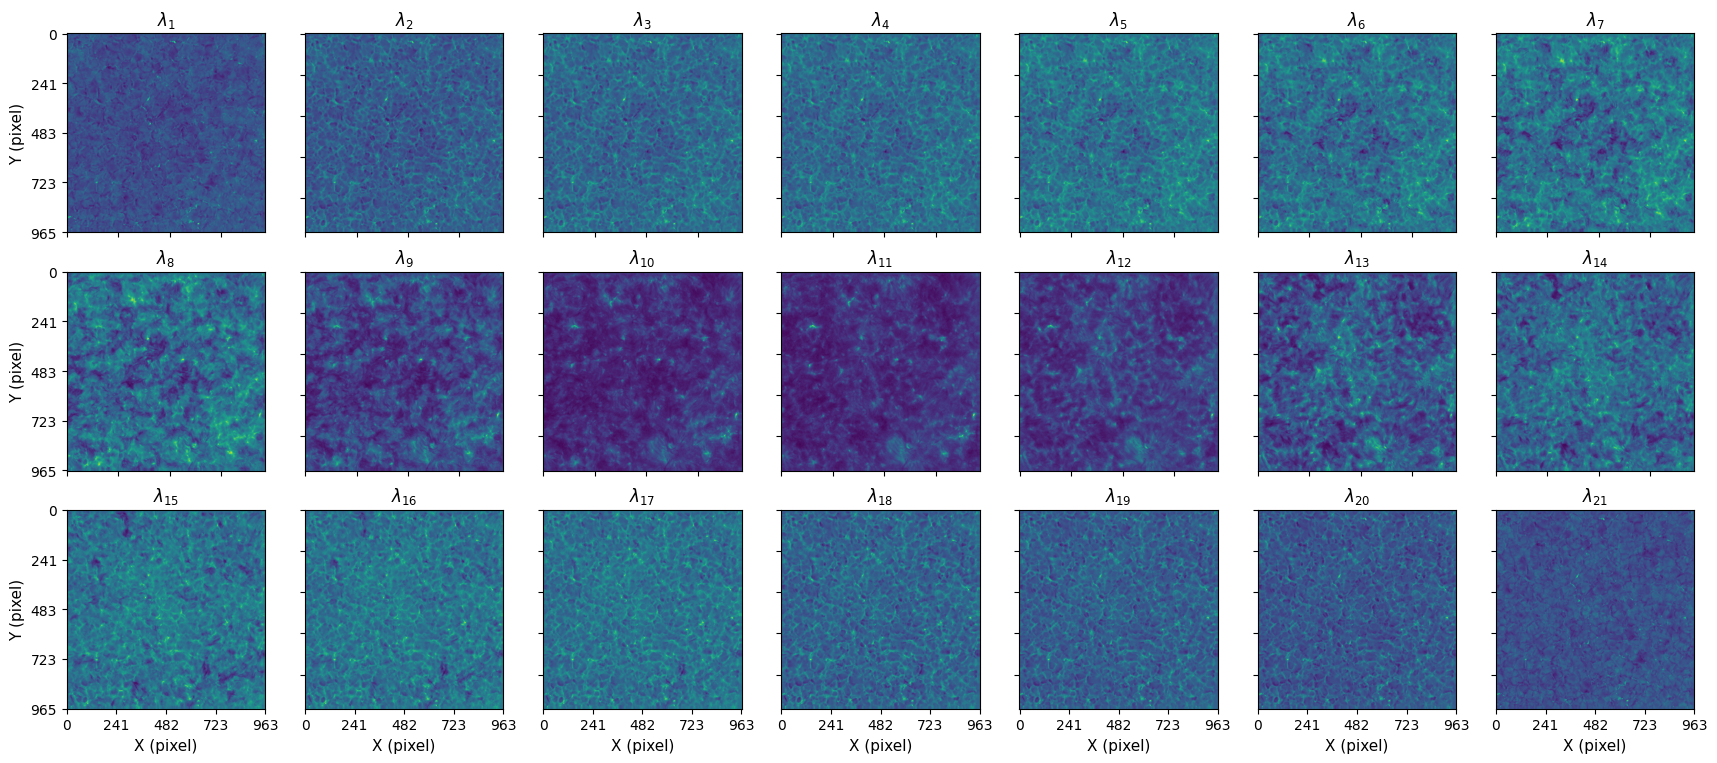

In [9]:
# Call the plot_data function to visualize the 'cube' dataset
plot_data(dataset=cube, num_columns=7,
          labels=wl_lbls, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='solar_dataset',
          hspace=0.1, wspace=0.2)

### Experiment Settings

#### Paremeters

In [10]:
# Define a list of loss functions to be used in the training process.
# The list includes L1 loss, MSE loss, and Smooth L1 loss.
loss_functions = [F.l1_loss, F.mse_loss, F.smooth_l1_loss]

# Define a list of sigma values to be used for Gaussian Fourier feature mapping or other purposes.
sigmas = [1., 10., 100.]

In [11]:
# Comment this line for complete training or uncomment for single training
# sigmas = [10.]

In [12]:
# Initialize an empty dictionary to store the configuration parameters for the experiment.
config = {}

# Store the hardware information (either CPU or GPU details) in the 'info' key of the config dictionary
config['HARDWARE'] = info()

# Set the index of the image to be used from the data cube.
config['IMG_INDEX'] = [11]

# Set the size of the image crop to be used for training.
config['CROP_SIZE'] = 512

# Set the dimension of the Fourier feature mapping matrix (M). The total number of Fourier features will be 2M.
config['M'] = 128

# Set the value of sigma for Gaussian Fourier feature mapping, using the fourth value from the 'sigmas' list.
# config['SIGMA'] = sigmas[1]
config['SIGMA'] = sigmas[0]

# Set the learning rate for the optimizer.
config['LR'] = 1e-4

# Set the loss function to be used for training, using the second function from the 'loss_functions' list.
config['LOSS'] = loss_functions[1]

# Set the number of epochs for training.
config['EPOCHS'] = 2000

#### Fourier features

<p align="justify">The first attempt will be to verify the architecture, among all the possibilities that have been recently suggested, that best approximates the pseudomonochromatic images. We use neural fields, also known as "implicit neural representations": A neural field applied to a pixelated image consists of a neural network that takes the coordinates (𝑥, 𝑦) of the pixel as inputs and outputs its RGB value (in this case, the pixel's intensity). When a trained neural field is queried to output values for all pixels, the image is reconstructed. A neural field is, therefore, a continuous and differentiable function that approximates a function defined in a space, in our case 𝐼(𝑥, 𝑦).</p>

#### Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$.

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$.

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$,
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $N(0,\sigma)$

In [13]:
# Initialize an empty dictionary to store different Fourier mapping matrices
B = {}

# Add a 'none' key to the dictionary with a value of None, indicating no Fourier mapping
# comment for single training
B['none'] = None

# Add a 'basic' key to the dictionary with a 3x3 identity matrix as its value
# This represents the basic Fourier mapping
# comment for single training
B['basic'] = torch.eye(3).to(device)

# Loop over a list of sigma values sigmas to generate Gaussian Fourier mapping matrices
for s in sigmas:
    # Generate a Gaussian Fourier mapping matrix with 'm' features and standard deviation 'sigma'
    # Store the generated matrix in the dictionary with a key that includes the sigma value
    B[f'gauss_{s}'] = generate_B(m=config['M'], sigma=s, device=device)

#### Obtaining the image for the experiment

In [14]:
# Retrieve one of the images from the cube dataset using the specified index from the config dictionary
images = get_experiment_data(cube, config['IMG_INDEX'])

# Crop the image to create a patch of size (CROP_SIZE x CROP_SIZE) as specified in the config dictionary
images = crop(images, config['CROP_SIZE'])

# Save GT image to config dictionary
config['GT_IMG'] = images

# Normalize the pixel intensity values of the image to the range [0, 1] using feature scaling
images, (min, max) = feat_scaling(images)

# Create an array of wavelengths ranging from config['IMG_INDEX'] array
wavelengths = np.array(config['IMG_INDEX'])

# Create labels for the wavelengths. The labels are in the format 'λ_n'
lbls = [f'$\\lambda_{{{label + 1}}}$' for label in wavelengths]

# Initialize a Compose object from torchvision.transforms to apply a sequence of transformations.
# In this case, the only transformation is Normalize,
# which normalizes the tensor with a mean of 0.5 and a standard deviation of 0.5.
# transform = Compose([
#  Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
# ])

# Apply the normalization transformation to tensor_norm.
# This will shift and scale the values in tensor_norm to be between -1 and 1.
# images = transform(images)

#### Obtaining the grid of normalized coordinates

In [15]:
# Obtain the grid of normalized coordinates in the interval [0, 1]
coords = grid3D(images)

# Save the grid to config dictionary
config['COORDS_VAL'] = coords

# Obtain the grid of normalized coordinates in the interval [-1, 1]
# coords = grid3D(data=images, ini_dim=-1)

#### Getting the training and test datasets

In [16]:
# Use the function to split the data into training and testing sets.
train_loader, test_loader = split_data_2D(coords, images, wavelengths, device=device)

# If using SolarFlatDataset, the tensors need to be reorganized
# The 'coords' and 'normalized_tensor' are permuted to match the expected input shape for SolarFlatDataset
# 'wavelengths' and 'device' are also passed as arguments to the data splitting function 'split_data_2D'
# 'ds_type=SolarFlatDataset' specifies that the SolarFlatDataset class should be used for handling the data
# train_loader, test_loader = split_data_2D(coords.permute(2, 3, 0, 1), normalized_tensor.permute(2, 3, 0, 1),
#                                          wavelengths, ds_type=SolarFlatDataset, device=device)

#### Info

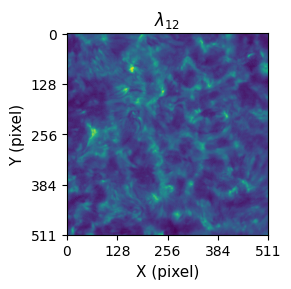

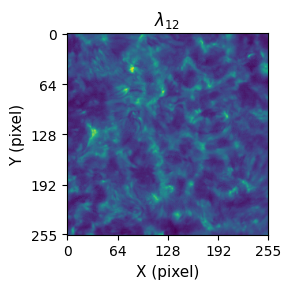

Coordinates: torch.Size([1, 3, 512, 512])
Image: torch.Size([1, 1, 512, 512])
Coordinates train: torch.Size([1, 3, 256, 256])
Image train: torch.Size([1, 1, 256, 256])
First batch coords: torch.Size([1, 3, 256, 256])
First batch labels: torch.Size([1, 1, 256, 256])


In [17]:
# Plot the image using the 'plot_data' function, squeezing and converting it to a NumPy array.
# Also, set the label size and font size for the plot.
plot_data(images.squeeze().numpy(), labels=lbls, tick_size=10,
          title_size=12, axis_size=11, path=IMAGES_PATH, img_name='test_data')

# Downsample the coordinates by taking every other pixel along the width and height.
coords_train = coords[:, :, ::2, ::2]

# Downsample the image by taking every other pixel along the width and height.
images_train = images[:, :, ::2, ::2]

# Plot the image_train using the 'plot_data' function, squeezing and converting it to a NumPy array.
# Also, set the label size and font size for the plot.
plot_data(images_train.squeeze().numpy(), labels=lbls, tick_size=10,
          title_size=12, axis_size=11, path=IMAGES_PATH, img_name='train_data')

# Print the minimum and maximum pixel intensity values of the image.
# print(f'Min: {min.item():.4f} Max: {max.item():.4f}')

# Print the shape of the original coordinates tensor.
print(f'Coordinates: {coords.shape}')

# Print the shape of the original image tensor.
print(f'Image: {images.shape}')

# Print the shape of the downsampled coordinates tensor.
print(f'Coordinates train: {coords_train.shape}')

# Print the shape of the downsampled image tensor.
print(f'Image train: {images_train.shape}')

# Retrieve the next batch of data and labels from the test_loader
x, y, _ = next(iter(train_loader))

# Print the shape of the batch data
print(f'First batch coords: {x.shape}')

# Print the shape of the batch labels
print(f'First batch labels: {y.shape}')

### Obtain an instance of the Neural Field model with Fourier Features

In [18]:
# Neural field function
def instance_ff(lr=1, m=1, device='cpu'):
    """
    Create an instance of a Neural Field model along with its optimizer.

    Parameters:
        lr (float): Learning rate for the optimizer.
        m (int): The number of Fourier projections. Used to determine the input size of the model.

    Returns:
        model (NeuralFieldFF object): An instance of the NeuralFieldFF model.
        optimizer (torch.optim.Adam object): An instance of the Adam optimizer.
    """

    # Determine the input size 'k' based on the number of Fourier projections 'm'
    if m == 1:
        k = 3
    else:
        k = 2 * m

    # Initialize the NeuralFieldFF model with the determined input size and move it to the device
    model = NeuralFieldFF(input_size=k, hidden_layers=3).to(device)

    # Initialize the Adam optimizer with the given learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Return the model and optimizer instances
    return model, optimizer

### Training routine function

In [19]:
def train_model(model, optimizer, config, train_loader, val_loader,
                B, process=False, epochs=config['EPOCHS'],
                base_dir=None, filename=None):

    # Check if Fourier mapping is to be applied
    if B is None:
        fm = None
        B = None
    else:
        fm = fourier_mapping  # Fourier mapping function
        B = B  # Fourier mapping matrix

    # Record the start time for training
    start_time = time.time()

    #################################################################
    # Perform the training using the specified loss function,
    # optimizer, and other configurations
    output, best = train(model=model, optimizer=optimizer,
                         loss_fn=config['LOSS'], epochs=epochs,
                         train_loader=train_loader, test_loader=val_loader,
                         print_every=500,
                         fm=fm, B=B,
                         device=device,
                         process=process,
                         base_dir=base_dir, filename=filename)
    #################################################################

    # Record the end time for training
    end_time = time.time()

    # Calculate and store the total training time
    config['TRAINING_TIME'] = time_formatter(end_time - start_time)

    # Print the total training time
    print(f"El tiempo total de entrenamiento fue de {config['TRAINING_TIME']}.")

    return output, best

### Training

In [20]:
# Initialize dictionaries to store the trained models and their corresponding output information
models = {}
dics = {}

# Loop through each Fourier feature mapping configuration stored in the dictionary 'B'
for s in tqdm(B):
    # If there's no Fourier feature mapping, instantiate a standard MLP model
    if s == 'none':
        model_ff, optimizer_ff = instance_ff(lr=config['LR'], device=device)
    # If basic Fourier feature mapping is used, instantiate an MLP model with an input size of 3
    elif s == 'basic':
        model_ff, optimizer_ff = instance_ff(lr=config['LR'], m=3, device=device)
    # Otherwise, instantiate an MLP model with an input size based on the shape of the Fourier feature mapping matrix 'B'
    else:
        model_ff, optimizer_ff = instance_ff(lr=config['LR'], m=B[s].shape[0], device=device)

    # Train the instantiated model and get the output and the best model
    print(s)

    # Save all training images for none and gauss_10.0 mapping
    # process = True if s=='none' or s=='gauss_10.0' else False
    process = False

    # epochs = 4000 if s=='none' else config['EPOCHS']

    base_dir = LOGS_PATH
    filename = f"{GPU}/σ={s}"

    output_ff, best_ff = train_model(model_ff, optimizer_ff, config,
                                     train_loader, test_loader, B=B[s],
                                     process=process, epochs=config['EPOCHS'],
                                     base_dir=base_dir, filename=filename)

    # Store the best model in the 'models' dictionary
    models[s] = copy.deepcopy(best_ff)

    # Add a deep copy of the configuration used for this model to the 'best' dictionary
    output_ff['config'] = config

    # Add the Fourier feature mapping matrix 'B' to the output dictionary
    output_ff['B'] = B[s]

    # Store the output information in the 'dics' dictionary
    for key, value in output_ff.items():
        if isinstance(value, torch.Tensor):
            output_ff[key] = value.detach()

    dics[s] = copy.deepcopy(output_ff)

  0%|          | 0/5 [00:00<?, ?it/s]

none


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0097, test Loss: 0.0097
PSNR: 20.1492, test PSNR: 20.1464
Epoch 1000/2000, Loss: 0.0091, test Loss: 0.0091
PSNR: 20.4140, test PSNR: 20.4105
Epoch 1500/2000, Loss: 0.0080, test Loss: 0.0080
PSNR: 20.9592, test PSNR: 20.9540
Epoch 2000/2000, Loss: 0.0070, test Loss: 0.0070
PSNR: 21.5545, test PSNR: 21.5481
El tiempo total de entrenamiento fue de 1.0 minute 26.41 seconds.
basic


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0082, test Loss: 0.0082
PSNR: 20.8374, test PSNR: 20.8360
Epoch 1000/2000, Loss: 0.0044, test Loss: 0.0044
PSNR: 23.6042, test PSNR: 23.5947
Epoch 1500/2000, Loss: 0.0031, test Loss: 0.0031
PSNR: 25.1455, test PSNR: 25.1411
Epoch 2000/2000, Loss: 0.0025, test Loss: 0.0025
PSNR: 26.0496, test PSNR: 26.0286
El tiempo total de entrenamiento fue de 1.0 minute 34.15 seconds.
gauss_1.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0036, test Loss: 0.0036
PSNR: 24.3936, test PSNR: 24.3998
Epoch 1000/2000, Loss: 0.0014, test Loss: 0.0013
PSNR: 28.6646, test PSNR: 28.7599
Epoch 1500/2000, Loss: 0.0010, test Loss: 0.0010
PSNR: 29.8674, test PSNR: 29.8427
Epoch 2000/2000, Loss: 0.0010, test Loss: 0.0010
PSNR: 29.9231, test PSNR: 30.0930
El tiempo total de entrenamiento fue de 2.0 minutes 10.14 seconds.
gauss_10.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0005, test Loss: 0.0005
PSNR: 33.4251, test PSNR: 33.3661
Epoch 1000/2000, Loss: 0.0002, test Loss: 0.0002
PSNR: 37.2027, test PSNR: 36.7282
Epoch 1500/2000, Loss: 0.0001, test Loss: 0.0002
PSNR: 38.6506, test PSNR: 37.6909
Epoch 2000/2000, Loss: 0.0001, test Loss: 0.0002
PSNR: 39.6251, test PSNR: 38.2211
El tiempo total de entrenamiento fue de 2.0 minutes 11.72 seconds.
gauss_100.0


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 0.0086, test Loss: 0.0098
PSNR: 20.6357, test PSNR: 20.0953
Epoch 1000/2000, Loss: 0.0011, test Loss: 0.0129
PSNR: 29.4713, test PSNR: 18.8839
Epoch 1500/2000, Loss: 0.0005, test Loss: 0.0152
PSNR: 33.4011, test PSNR: 18.1872
Epoch 2000/2000, Loss: 0.0002, test Loss: 0.0164
PSNR: 36.0282, test PSNR: 17.8515
El tiempo total de entrenamiento fue de 2.0 minutes 8.01 seconds.


In [21]:
models

{'none': NeuralFieldFF(
   (model): Sequential(
     (0): Linear(in_features=3, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): ReLU()
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): ReLU()
     (8): Linear(in_features=256, out_features=1, bias=True)
     (9): Sigmoid()
   )
 ),
 'basic': NeuralFieldFF(
   (model): Sequential(
     (0): Linear(in_features=6, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): ReLU()
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): ReLU()
     (8): Linear(in_features=256, out_features=1, bias=True)
     (9): Sigmoid()
   )
 ),
 'gauss_1.0': NeuralFieldFF(
   (model): Sequential(
     (0): Linear(in_features=256, 

### Outputs

#### Get the best generated images from each model

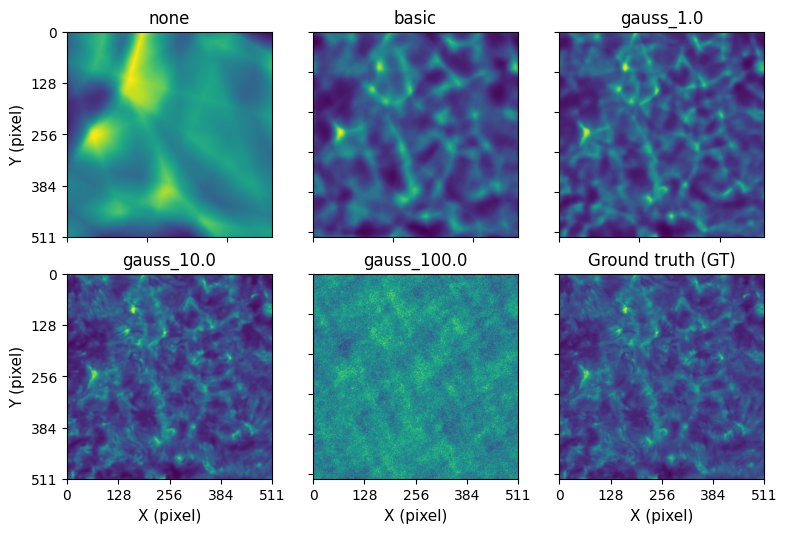

In [22]:
# Initialize empty lists to store the best generated images and their corresponding labels
best = []
labels = []

# Loop through the dictionary containing the output information for each Fourier feature mapping type
for s in dics:
    # Append the best generated image for the current SIREN model to the 'best' list
    best.append(dics[s]['best_test_generated'].detach().cpu())
    # Append the label (SIREN omega) to the 'labels' list
    labels.append(s)

# Append the ground truth image to the 'best' list
best.append(images)
# Append the label 'Ground truth (GT)' to the 'labels' list
labels.append('Ground truth (GT)')

# Concatenate all the best generated images and the ground truth image along dimension 0
# Then, remove the singleton dimensions and convert the tensor to a NumPy array
generated_images = torch.cat(best, dim=0).squeeze().numpy()

# Utilizes the 'plot_data' function from the 'utils' module to display the images.
# The images are arranged in a grid with 3 columns, and each image is labeled according to the 'labels' list.
plot_data(dataset=generated_images, num_columns=3,
          labels=labels, tick_size=10,
          title_size=12, axis_size=11,
          path=IMAGES_PATH, img_name='generated_and_GT',
          hspace=0.1, wspace=0.2)

#### Graphical representation of metrics for the training and test sets

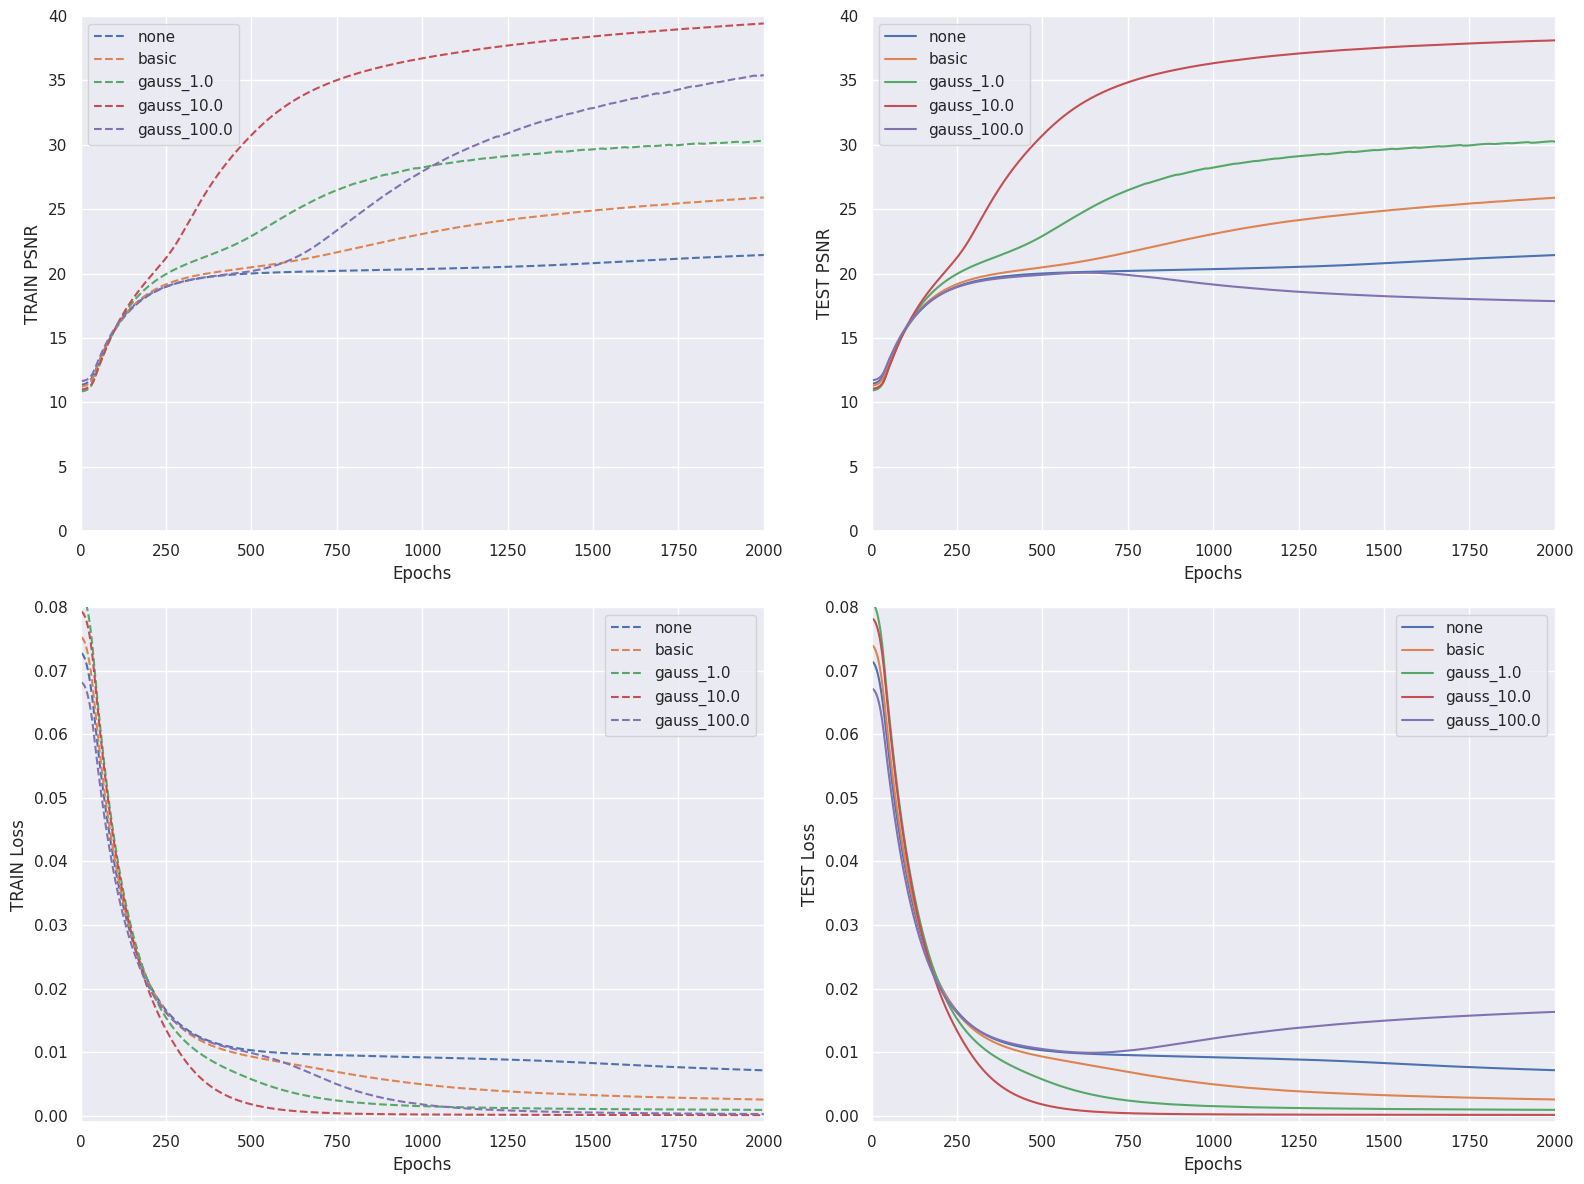

In [23]:
# from seaborn.relational import lineplot
# Set the Seaborn theme for better visualization
seaborn.set()
seaborn.set_theme()

# Create a figure and axes with two rows and two columns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Generate x-values based on the number of epochs
xs = np.arange(1, config['EPOCHS'] + 1)

# Define metrics and their corresponding y-axis labels
metrics = ['psnr', 'test_psnr', 'loss', 'test_loss']
y_labels = ['TRAIN PSNR', 'TEST PSNR', 'TRAIN Loss', 'TEST Loss']

# Define y-axis limits for PSNR and Loss plots
y_limits = [(0, 40), (0, 40), (-0.001, 0.08), (-0.001, 0.08)]

# Loop through each subplot to plot the data
for i, ax in enumerate(axs.flatten()):
    metric = metrics[i]  # Get the metric to be plotted for this subplot
    # Set the line style based on the subplot index (even or odd)
    if (i % 2 == 0):
        line = '--'  # Dashed line for even-indexed subplots
    else:
        line = '-'  # Solid line for odd-indexed subplots

    y_label = y_labels[i]  # Get the y-axis label for this subplot
    y_min, y_max = y_limits[i]  # Get the y-axis limits for this subplot

    # Plot the smoothed curve for each dictionary in 'dics'
    for k in dics:
        ax.plot(xs, smooth_curve(dics[k][metric], .99),
                label=k, linestyle=line)

    # Set subplot title, labels, and legend
    ax.set_title('')
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epochs')
    ax.legend()

    # Adjust the axis limits
    ax.set_xlim(left=0)
    ax.set_xlim(right=2000)
    ax.set_ylim(bottom=0)

    # Adjust the position of the axes to start at the origin
    ax.spines['left'].set_position('zero')
    # ax.spines['bottom'].set_position('zero')

    # Remove the top and right spines for better visualization
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Set the y-axis limits based on the predefined values
    ax.set_ylim(y_min, y_max)


# Adjust the spacing between the plots to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Reset the plot settings to default
plt.rcdefaults()

#### Save models

In [24]:
# Loop through each dictionary in 'dics' to save
# the corresponding model and dictionary
for i, s in enumerate(dics):
    # Save the model's state dictionary to a .pth file
    torch.save(models[s].state_dict(), MODEL_PATH + f"{i}_MODEL_FF2D_{s}.pth")

    # Save the entire dictionary to a .pth file
    torch.save(dics[s], MODEL_PATH + f"{i}_DIC_FF2D_{s}.pth")

In [25]:
for k in dics[k]:
  print(k)

loss
psnr
test_loss
test_psnr
lr
history_images
best_test_psnr
best_epoch
best_train_generated
best_train_index
best_test_generated
best_test_index
config
B


### Load and test Models

In [26]:
# Initialize a NeuralFieldFF model without a mapping matrix. This model has an input size of 3
# and consists of 3 hidden layers. It's designed for tasks where direct input features are used
# without transformation via a Fourier features mapping matrix or similar.
model_none = NeuralFieldFF(input_size=3, hidden_layers=3)

# Load the state dictionary for the model from a file, ensuring it's loaded onto the CPU.
# This particular model file ('0_MODEL_FF2D_none.pth') does not include a Fourier features mapping matrix,
# indicating it relies on direct input features.
model_none.load_state_dict(torch.load(MODEL_PATH + '0_MODEL_FF2D_none.pth',
                                    map_location=torch.device('cpu')))

# Load the dictionary containing additional information and configuration for the model.
# This dictionary corresponds to the model without a Fourier features mapping matrix.
dic_none = torch.load(MODEL_PATH + '0_DIC_FF2D_none.pth',
                    map_location=torch.device('cpu'))

# Extract the configuration settings from the loaded dictionary. This configuration
# likely contains model parameters, training settings, and other metadata specific
# to the model without a mapping matrix.
config_none = dic_none['config']


In [27]:
# Define the size of the model input (k). In this case, it's twice the value of m, which is 128.
# This results in an input size of 256 for the Fourier Features (FF) model.
m = 128
ff_model_10 = NeuralFieldFF(input_size=(2*m), hidden_layers=3)

# Load the state dictionary for the FF model from a file, ensuring it's loaded onto the CPU.
# This model specifically utilizes Fourier features, where the mapping matrix
# has a standard deviation of 10.0
ff_model_10.load_state_dict(torch.load(MODEL_PATH + '3_MODEL_FF2D_gauss_10.0.pth',
                                    map_location=torch.device('cpu')))

# Load the dictionary containing additional information and configuration for the model.
ff_dic_10 = torch.load(MODEL_PATH + '3_DIC_FF2D_gauss_10.0.pth',
                    map_location=torch.device('cpu'))

# Extract the configuration settings from the loaded dictionary. This configuration likely
# contains model parameters, training settings, and other metadata.
config_ff_10 = ff_dic_10['config']


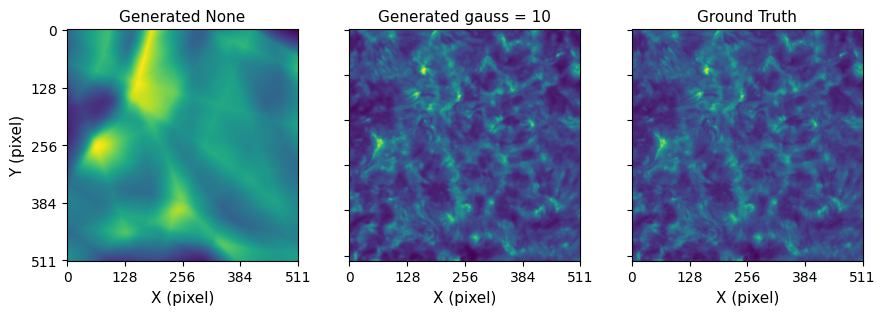

In [28]:
# Set the models to evaluation mode. This is important because it tells the model to behave in inference mode,
# disabling specific layers or behaviors like dropout or batch normalization, which are only used during training.
model_none.eval()
ff_model_10.eval()

# Pass the selected image coordinates to the simple models to generate the output.
result_none = model_none(config_none['COORDS_VAL'])

#Applies a Gaussian Fourier mapping to normalized spatial coordinates.
fm = fourier_mapping(x=config_ff_10['COORDS_VAL'], B=ff_dic_10['B'])
# Pass the selected image coordinates to the model to generate the output.
result_ff_10 = ff_model_10(fm)

# Concatenate `result` and `gt_image` along the batch dimension (dim=0)
# This assumes that `result` already has a shape of [1, C, H, W]
combined_images = torch.cat((result_none, result_ff_10, config_ff_10['GT_IMG']), dim=0).detach().squeeze().numpy()

# Plotting the generated and ground truth images side by side for comparison.
plot_data(dataset=combined_images, num_columns=3,
          labels=['Generated None', 'Generated gauss = 10', 'Ground Truth'], tick_size=10,
          title_size=11, axis_size=11,
          path=IMAGES_PATH, img_name='comparison_generated_vs_ground_truth',
          hspace=0.1, wspace=0.2)


In [29]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import imageio

def stamp(history_images):
  # Prepare the images and stamp information on them
  converted_images = []
  for idx, img in enumerate(history_images):
      if idx % 5 == 0:
          # Remove batch dimension and convert to numpy for processing
          img = img.squeeze().detach().numpy()
          # Apply colormap
          img_mapped = plt.cm.viridis(img)
          # Convert to uint8
          img_mapped = (img_mapped[:, :, :3] * 255).astype(np.uint8)

          # Convert the numpy array to a PIL image object for editing
          pil_img = Image.fromarray(img_mapped)
          draw = ImageDraw.Draw(pil_img)

          # Optional: specify a font
          # font = ImageFont.truetype("arial.ttf", size=12)

          # Draw text (epoch number) in the top left corner
          # If font is omitted, PIL's default font is used
          lbl = idx + 5 if idx > 0 else 0

          draw.text((10, 10), f"Epoch {lbl}", fill="white")  # , font=font

          # Convert back to a numpy array to save in the video
          img_with_text = np.array(pil_img)
          converted_images.append(img_with_text)

  return converted_images

In [30]:
# Save the processed images as a video
def save_video(images, output_path):
  imageio.mimwrite(output_path, images, fps=20)

In [31]:
# Stamp information on images
ff_10_images = stamp(ff_dic_10['history_images'])
none_images = stamp(dic_none['history_images'])

In [32]:
# Define output path for video files
output_path_ff_10 = f'{VIDEO_PATH}/FF_learning_annotated.mp4'
output_path_none = f'{VIDEO_PATH}/none_learning_annotated.mp4'

In [33]:
# Save videos
save_video(images=ff_10_images, output_path=output_path_ff_10)
save_video(images=none_images, output_path=output_path_none)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [34]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"  # Establece JAX para usar la CPU
# import jax  # Después de establecer la variable de entorno

# Code to display the video in Jupyter Notebook (optional)
from IPython.display import HTML
from base64 import b64encode

def show_video(output_path):
  # Read the video file and encode it for embedding in HTML
  mp4 = open(output_path, 'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  # Embed the video in the notebook
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [35]:
show_video(output_path_ff_10)

In [36]:
show_video(output_path_none)